# SSD Evaluation Tutorial

This is a brief tutorial that explains how compute the average precisions for any trained SSD model using the `Evaluator` class. The `Evaluator` computes the average precisions according to the Pascal VOC pre-2010 or post-2010 detection evaluation algorithms. You can find details about these computation methods [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#sec:ap).

As an example we'll evaluate an SSD300 on the Pascal VOC 2007 `test` dataset, but note that the `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the evaluation on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

Note: I that in case you would like to evaluate a model on MS COCO, I would recommend to follow the [MS COCO evaluation notebook](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_evaluation_COCO.ipynb) instead, because it can produce the results format required by the MS COCO evaluation server and uses the official MS COCO evaluation code, which computes the mAP slightly differently from the Pascal VOC method.

Note: In case you want to evaluate any of the provided trained models, make sure that you build the respective model with the correct set of scaling factors to reproduce the official results. The models that were trained on MS COCO and fine-tuned on Pascal VOC require the MS COCO scaling factors, not the Pascal VOC scaling factors.

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator
from models.keras_ssd7 import build_model
%matplotlib inline

Using TensorFlow backend.
/jet/prs/workspace/ssd_keras/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


In [2]:
# Set a few configuration parameters.
img_height = 300
img_width = 480
n_classes = 42
model_mode = 'inference'

In [3]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 42 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, 3),
                    n_classes=n_classes,
                    mode=model_mode,
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

model.load_weights('SSD7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Or

### 1.2. Load a trained model

We set `model_mode` to 'inference' above, so the evaluator expects that you load a model that was built in 'inference' mode. If you're loading a model that was built in 'training' mode, change the `model_mode` parameter accordingly.

In [5]:
# # TODO: Set the path to the `.h5` file of the model to be loaded.
# model_path = 'path/to/trained/model.h5'

# # We need to create an SSDLoss object in order to pass that to the model loader.
# ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

# K.clear_session() # Clear previous models from memory.

# model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
#                                                'L2Normalization': L2Normalization,
#                                                'DecodeDetections': DecodeDetections,
#                                                'compute_loss': ssd_loss.compute_loss})

## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [6]:
dataset = DataGenerator(load_images_into_memory=True)

# TODO: Set the paths to the dataset here.
# Pascal_VOC_dataset_images_dir = '../../datasets/VOCdevkit/VOC2007/JPEGImages/'
# Pascal_VOC_dataset_annotations_dir = '../../datasets/VOCdevkit/VOC2007/Annotations/'
# Pascal_VOC_dataset_image_set_filename = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = np.arange(43)

images_dir = '/home/jet/data/'

# Ground truth
val_labels_filename   = '/home/jet/data/val_labels.csv'

dataset.parse_csv(images_dir=images_dir,
                        labels_filename=val_labels_filename,
                        input_format=['image_name', 'xmin',  'ymin', 'xmax','ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')


# dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
#                   image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
#                   annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
#                   classes=classes,
#                   include_classes='all',
#                   exclude_truncated=False,
#                   exclude_difficult=False,
#                   ret=False)

Loading images into memory: 100%|██████████| 384/384 [00:01<00:00, 212.68it/s]


## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [7]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=1,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 384

Producing predictions batch-wise: 100%|██████████| 384/384 [00:09<00:00, 39.44it/s]
Matching predictions to ground truth, class 1/42.: 100%|██████████| 744/744 [00:00<00:00, 31185.35it/s]
Matching predictions to ground truth, class 2/42.: 100%|██████████| 1514/1514 [00:00<00:00, 36104.55it/s]
Matching predictions to ground truth, class 3/42.: 100%|██████████| 425/425 [00:00<00:00, 34254.02it/s]
Matching predictions to ground truth, class 4/42.: 100%|██████████| 419/419 [00:00<00:00, 31214.05it/s]
Matching predictions to ground truth, class 5/42.: 100%|██████████| 452/452 [00:00<00:00, 33434.31it/s]
Matching predictions to ground truth, class 6/42.: 100%|██████████| 170/170 [00:00<00:00, 26528.45it/s]
Matching predictions to ground truth, class 7/42.: 100%|██████████| 392/392 [00:00<00:00, 33484.05it/s]
Matching predictions to ground truth, class 8/42.: 100%|██████████| 940/940 [00:00<00:00, 33892.78it/s]
Matching predictions to ground tr

## 4. Visualize the results

Let's take a look:

In [8]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

1             AP    0.421
2             AP    0.327
3             AP    0.387
4             AP    0.308
5             AP    0.335
6             AP    0.617
7             AP    0.196
8             AP    0.247
9             AP    0.096
10            AP    0.213
11            AP    0.527
12            AP    0.157
13            AP    0.246
14            AP    0.368
15            AP    0.131
16            AP    0.442
17            AP    0.298
18            AP    0.407
19            AP    0.333
20            AP    0.161
21            AP    0.311
22            AP    0.279
23            AP    0.654
24            AP    0.061
25            AP    0.526
26            AP    0.621
27            AP    1.0
28            AP    0.488
29            AP    0.545
30            AP    0.886
31            AP    1.0
32            AP    0.225
33            AP    0.511
34            AP    0.461
35            AP    0.354
36            AP    0.0
37            AP    0.0
38            AP    0.244
39            AP    

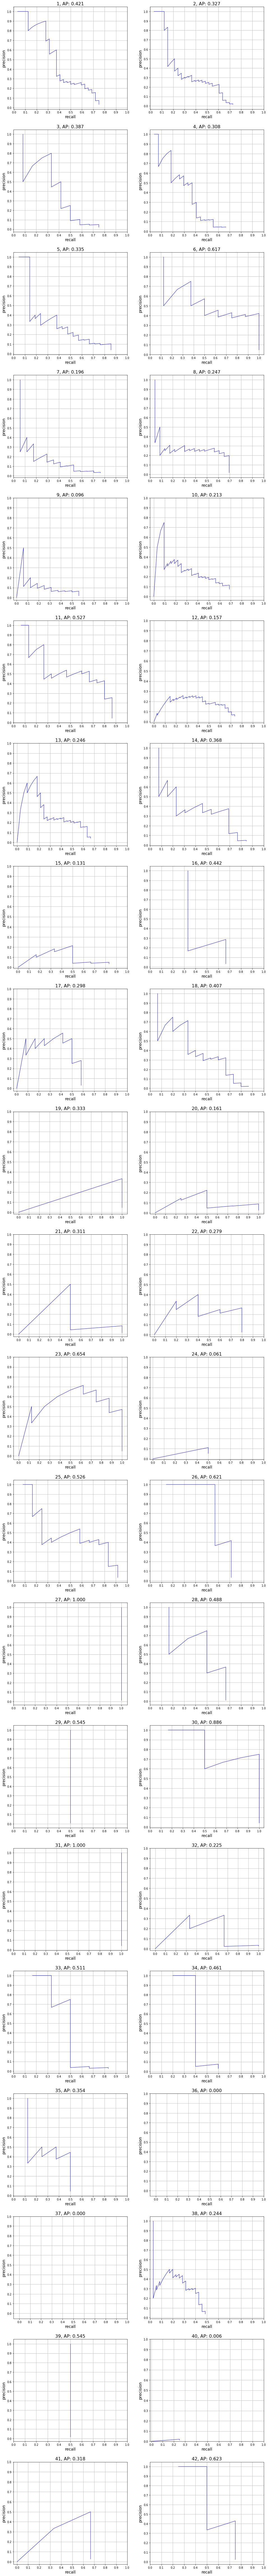

In [9]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)